# Chapter 6 Exercises - Linear Model Selection and Regularization

In [23]:
import numpy as np
import pandas as pd
from math import exp, log, sqrt, pi
import time
import itertools
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import scale, StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline

import os.path

## Conceptual

**1.(a)** Best subset will have the smallest training RSS. The approach considers all possible permutations of p predictors. Consequently, we will identify the best portfolio of *p* predictors for the training set. The drawback is that this model is likely to be overfitted to the training data and is computationally expensive.

**1.(b)** No one approach is guaranteed to the provide the best performing model, i.e., smallest test error.

- Best subset is problematic because of the challenges in transferring the best training model to test model. The features that produce the smallest training MSE do not neccessarily generate the smallest testing MSE. If able to properly translate the training MSE to the test MSE, then best subset like is most likley to produce the smallest test error.
- Forward stepwise is most unlikely to provide the lowest MSE because the approach does not random permutations. It linearly appends features based on the which feature provides the most information gain. However, the order of features may not align with the portfolio of features that create the best answer. For example, forward stepwise will never select feature 2 and feature 3 because it is required to start with feature 1, which on its own may provide the most information gain.
- Backward stepwise requires that the number of observations is greater than the number of features.

**1.(c)**<br>
i) True  
<br>
ii) True 
<br>
iii) False
<br>
iv)False
<br>
v) False

### Notes on Model Flexibility

Model flexibility is how much a model's behavior is influenced by the data's characteristics. The Ridge and Lasso penalities/shrinkage factors decrease the affect of the dataset's characteristics on the model's behavior. Consequently, the Right and Lasso are less flexible than least square estimates.

In general, the **more flexible** the model, the **less bias** (in aboslute value) and the **more variance** you'll get when predicting on the test dataset.

#### Rules of Thumb
1. Sample size is large and the number of predictors is small - A flexible model performs better. The larger the sample size, the less likely to overfit even when using a more flexible model. Meanwhile, a more flexible model tends to reduce bias.

2. Number of predictors is large and the sample size is small - An inflexible model performs better. A flexible model will cause overfitting because of the small sample size. This usually means a bigger inflation in variance and a small reduction in bias.

3. Relationship between the predictors and response is highly non-linear - A flexible performs better. A flexible model is required to find the non-linear effect.

4. Variance of the errors is large - An inflexible model performs better. A flexible model will capture too much of the noise in the data due to the large variance of the errors.

#### Lasso vs Least Squares

**2.(a).i** Incorrect - The Lasso is less flexible than least squares.

**2.(a).ii** Incorrect - The Lasso is less flexible than least squares.

**2.(a).iii** Correct - The Lasso's L2 penalty decreases the variance by constraining the influence of the dataset's characteristics. Some variables may be zero'ed out b/c of the shrinkage factors. This works well when the variance error is large or there are more features than observations.

**2.(a).iv** Incorrect - The Lasso decreases variance and increases bias.

#### Ridge vs Least Squares

**2.(b).i** Incorrect - The Ridge is less flexible than least squares.

**2.(b).ii** Incorrect - The Ridge is less flexible than least squares.

**2.(b).iii** Correct - The Ridge's L1 penalty decreases the variance by constraining the influence of the dataset's characteristics. The penalty decreases the values of the coefficients close to zero, but not to zero. This works well when the variance error is large or there are more features than observations.

**2.(b).iv** Incorrect - The Ridge decreases variance and increases bias.

#### Non-linear Methods vs Least Squares

**2.(c).i** Correct - PCR and PLS are more flexible as they can handle non-linear relationships. These models decrease the variance my coaslescing independent variables. This decreases the variances by decreasing the impact of any single feature. Consequently, the models increase the bias.

**2.(c).ii** Incorrect - PCR and PLS increase the bias and decrease the variance.

**2.(c).iii** Non-linear methods are more flexible than least squares.

**2.(c).iv** Incorrect - Non-linear methods are more flexible than least squares.

### Lasso Regression Coefficients

3.(a). As **s increases**, the **training RSS** will decrease initially and then eventually start increasing.

3.(b). As **s increases**, the **testing RSS** will decrease initially and then eventually start increasing.

3.(c). As **s increases**, the **variance** steadily decreases.

3.(d). As **s increases**, the **bias** steadily increases.

3.(e). As **s increases**, the **irreducible error** remains constant.

### Ridge Regression Coefficients

4.(a). As **lambda increases**, the **training RSS** will decrease initially and then eventually start increasing.

4.(b). As **lambda increases**, the **testing RSS** will decrease initially and then eventually start increasing.

4.(c). As **lambda increases**, the **variance** steadily decreases.

4.(d). As **lambda increases**, the **bias** steadily increases.

4.(e). As **lambda increases**, the **irreducible error** remains constant.


### Ridge vs. Lasso

 - The Ridge regression tends to give similar coefficient values to correlated variables. Meanwhile, the lasso may give quote different coefficient values to correlated variables.
 - In Ridge regression, each least squares coefficient is shrunken by the same proportion.
 - The Lasso shrinks each least squares coefficeint towards zero by a constant amount.

## Applied

In [2]:
path = os.path.abspath('..')
college = pd.read_csv(path + '\data\College.csv', index_col=0)

In [3]:
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [4]:
college.info()

<class 'pandas.core.frame.DataFrame'>
Index: 777 entries, Abilene Christian University to York College of Pennsylvania
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Private      777 non-null    object 
 1   Apps         777 non-null    int64  
 2   Accept       777 non-null    int64  
 3   Enroll       777 non-null    int64  
 4   Top10perc    777 non-null    int64  
 5   Top25perc    777 non-null    int64  
 6   F.Undergrad  777 non-null    int64  
 7   P.Undergrad  777 non-null    int64  
 8   Outstate     777 non-null    int64  
 9   Room.Board   777 non-null    int64  
 10  Books        777 non-null    int64  
 11  Personal     777 non-null    int64  
 12  PhD          777 non-null    int64  
 13  Terminal     777 non-null    int64  
 14  S.F.Ratio    777 non-null    float64
 15  perc.alumni  777 non-null    int64  
 16  Expend       777 non-null    int64  
 17  Grad.Rate    777 non-null    int64  
dtypes: 

Train Test Split

In [5]:
# Feature Engineering
college['is_private'] = college['Private'].apply(lambda x: 1 if x == 'Yes' else 0)

# Process the data
X = college.drop(['Grad.Rate', 'Private'], axis=1)
y = college['Grad.Rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 9.(b). Fit a linear model and report the test error

In [6]:
linear = LinearRegression()
linear.fit(X_train_scaled, y_train)
y_pred = linear.predict(X_test_scaled)

print("Linear Regression Test MSE: {:.4}".format(mean_squared_error(y_test, y_pred)))

Linear Regression Test MSE: 167.1


### 9.(b). Fit a Ridge. Choose Lambda using cross-validation

In [7]:
# alpha = lambda
alphas = [0, 1, 5, 10, 100]

# already scaled features
ridge = Ridge(normalize=True)
coefs = []

for a in  alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train_scaled, y_train)
    coefs.append(ridge.coef_)

np.shape(coefs)

(5, 17)

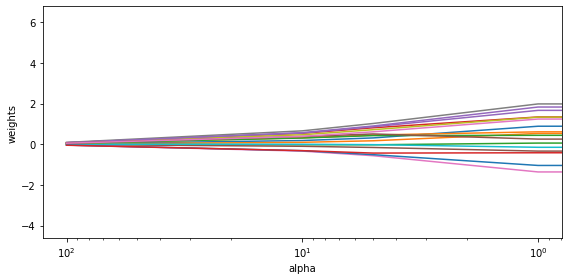

In [8]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylabel('weights')

fig.tight_layout();

#### Select optimal alpha using GridsearchCV

In [9]:
ridge = Ridge()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=3)

alphas = [0, 1, 5, 10, 100]
grid = dict()
grid['alpha'] = alphas

gsearch = GridSearchCV(ridge, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

results = gsearch.fit(X_train_scaled, y_train)

print('Best MSE: {:.5}'.format(results.best_score_))
print('Best Alpha: {}'.format(results.best_params_['alpha']))

Best MSE: -169.05
Best Alpha: 100


### Train and Predict Value setting Alpha = 100

In [10]:
alpha=100
ridge = Ridge(alpha=alpha)

ridge.fit(X_train_scaled, y_train)
y_pred = ridge.predict(X_test_scaled)

print("Ridge Test MSE: {:.4}".format(mean_squared_error(y_test, y_pred)))

Ridge Test MSE: 164.2


## 9.(d) Lasso

In [11]:
lasso = Lasso()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=3)

grid = dict()
alphas = [0, 1, 5, 10, 100]
grid['alpha'] = alphas

gsearch = GridSearchCV(lasso, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

results = gsearch.fit(X_train_scaled, y_train)

print('Best MSE: {:.5}'.format(results.best_score_))
print('Best Alpha: {}'.format(results.best_params_['alpha']))

Best MSE: -171.74
Best Alpha: 1


In [12]:
alpha=1
lasso = Lasso(alpha=alpha)

lasso.fit(X_train_scaled, y_train)
y_pred = lasso.predict(X_test_scaled)

print("Ridge Test MSE: {:.4}".format(mean_squared_error(y_test, y_pred)))

Ridge Test MSE: 175.5


## 9.(e). PCR

PCR is a regressor composed of two steps: first, PCA is applied to the training data, possibly performing dimensionality reduction; then, a regressor (e.g. a linear regressor) is trained on the transformed samples. In PCA, the transformation is purely unsupervised, meaning that no information about the targets is used. As a result, PCR may perform poorly in some datasets where the target is strongly correlated with directions that have low variance. 

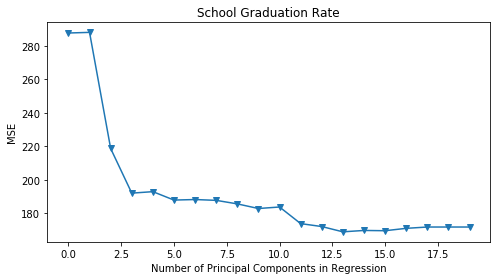

In [33]:
pca_model = PCA()
pca_model.fit(X_train)
X_train_reduced = pca_model.transform(X_train)
num_components_rng = np.arange(1, 20)

n = len(X_train_reduced)

linear_reg = LinearRegression(fit_intercept=True)
mse = []

kfold_10 = RepeatedKFold(n_splits=10, n_repeats=5, random_state=3)
#kfold_10 = KFold(n_splits=10, random_state=3)

# Calculate MSE for intercept only. No components.
score = -1 * cross_val_score(linear_reg, np.ones((n, 1)), y_train.ravel(), cv=kfold_10, scoring='neg_mean_squared_error').mean()
mse.append(score)

for i in num_components_rng:
    score = -1 * cross_val_score(linear_reg, X_train_reduced[:, :i], y_train.ravel(), cv=kfold_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.figure(figsize=(7,4))
plt.plot(mse, '-v')
plt.xlabel('Number of Principal Components in Regression')
plt.ylabel('MSE')
plt.title('School Graduation Rate')
plt.xlim(xmin=-1)
plt.tight_layout();


In [34]:
num_components = 11

pca_model_2 = PCA(n_components=num_components)
pca_model_2.fit(X_train_scaled)
X_train_reduced = pca_model_2.transform(X_train_scaled)

X_test_reduced = pca_model_2.transform(X_test_scaled)

lin_reg = LinearRegression()
lin_reg.fit(X_train_reduced, y_train)

y_pred = lin_reg.predict(X_test_reduced)
print("PCR MSE: ", mean_squared_error(y_test, y_pred))

PCR MSE:  162.38497705295913


In [41]:
print("X_train_scaled Shape: ", X_train_scaled.shape)
print("X_train_reduced Shape: ", X_train_reduced.shape)
print("\n")
print("X_test_scaled Shape: ", X_test_scaled.shape)
print("X_test_reduced Shape: ", X_test_reduced.shape)


X_train_scaled Shape:  (621, 17)
X_train_reduced Shape:  (621, 11)


X_test_scaled Shape:  (156, 17)
X_test_reduced Shape:  (156, 11)


In [39]:
X_test_scaled.shape

(156, 17)

## 9.(f). PLS

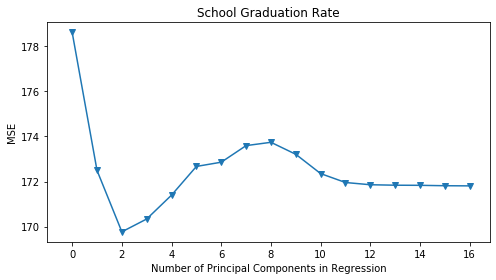

In [44]:
num_components_rng = np.arange(1, 18)

n = len(X_train_scaled)
mse = []

kfold_10 = RepeatedKFold(n_splits=10, n_repeats=5, random_state=3)
#kfold_10 = KFold(n_splits=10, random_state=3)

for i in num_components_rng:
    pls = PLSRegression(n_components=i)
    score = -1 * cross_val_score(pls, X_train_scaled, y_train, cv=kfold_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.figure(figsize=(7,4))
plt.plot(mse, '-v')
plt.xlabel('Number of Principal Components in Regression')
plt.ylabel('MSE')
plt.title('School Graduation Rate')
plt.xlim(xmin=-1)
plt.tight_layout();

In [46]:
num_components = 2
pls = PLSRegression(n_components=2)
pls.fit(X_train_scaled, y_train)

y_pred = pls.predict(X_test_scaled)

print("PLS MSE: ", mean_squared_error(y_test, y_pred))

PLS MSE:  170.5795479144816
